In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats
import scipy
import math
import random
from scipy.stats import binom_test
from scipy.stats import kstest
from scipy.stats import norm
import sys 
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import poisson
import random
import numpy as np
from numpy.random import random
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator



def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

class Model:
    def __init__(self):
        self.df = self.readindata() # processes our data into one dataframe
        self.cumprobdf = self.generatecumdata() # generates a cumulative probability dataframe
        self.binomialestimates = self.generatefinalbinomest() # returns final binomial estimates given observed all the data

    def clopper_pearson(self,x, n, alpha=0.05):
        """Estimate the confidence interval for a sampled Bernoulli random
        variable.
        `x` is the number of successes and `n` is the number trials (x <=
        n). `alpha` is the confidence level (i.e., the true probability is
        inside the confidence interval with probability 1-alpha). The
        function returns a `(low, high)` pair of numbers indicating the
        interval on the probability.
        """
        
        b = scipy.stats.beta.ppf
        lo = b(alpha / 2, x, n - x + 1)
        hi = b(1 - alpha / 2, x + 1, n - x)
        return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi


    def readindata(self):
        k1 = pd.read_csv('keywordlist1.txt',sep = ';',header=None)
        keys = k1[0]
        keys1 = keys.to_list()
        k2 = pd.read_csv('keywordlist2.txt',sep = ';',header=None)
        keys2 = k2[0].to_list()
        
        df1 = pd.read_csv('combined.csv', sep = ';', header = None,on_bad_lines='skip',names = ['Link'] + keys1 + ['Date','a26'])
        df1 = df1.dropna(subset = 'Date')
        
        df2 = pd.read_csv('set2_combined.csv', sep = ';', header = None,on_bad_lines='skip',names = ['Link'] + keys2 + ['Date','b26'])
        df2 = df2.dropna(subset = 'Date')

        #Perform outer join
        df = pd.merge(df1,df2,how = 'outer')
        df['Date'] = [elem.split(sep='T')[0] for elem in df['Date']]
        df['Date'] = [datetime.strptime(elem,"%Y-%m-%d") for elem in df['Date']]
        #df['Date'] = [elem.strftime('%Y-%m') for elem in df['Date']]
        #Convert date format

        #Create a counter of the number of articles so when resampling, we attain the number of articles per day
        df['NumOfArticles'] = [1 for i in range(len(df['Date']))]

        #Drop columns a26 and b26 and the list of links
        del df['a26']
        del df['b26']
        del df['Link']

        #Set index to equal date and get rid of that column
        df.index = df['Date']
        del df['Date']

        #For each row, if the element appears in the article set equal to 1 else 0
        for column in list(df):
            df[column] = [1 if elem>0 else 0 for elem in df[column]]
            
        #Group by day
        df = df.resample('D').sum()

        #Select start and end dates
        df =df.loc['2022-02-02':'2023-2-10']
        print("Process our DataFrame:                   Successfully parsed and formatted our data")
        df.to_csv('./processeddata.csv')
        return(df) # returns processed dataframe

    def generatecumdata(self):
        #Create a dataframe that computes the cumulative probability up until that date of a keyword occuring
        cumprob = self.df.copy()

        #Generates cumulative sum
        for column in list(cumprob)[:-1]:
            cumprob[column] = [sum(cumprob[column][:i+1])/sum(cumprob['NumOfArticles'][:i+1]) for i in range(0,len(cumprob[column]))]
        cumprob['NumOfArticles'] =np.cumsum(cumprob['NumOfArticles'])

        #Compute Binomial Estimates
        binomestimates = [sum(self.df[column])/sum(self.df['NumOfArticles']) for column in list(self.df)[:-1]]

        #Check that estimates line up with cumulative probaiblities at the end of the dataframe
        for i in range(0,len(cumprob.iloc[-1][:-1])):
            if (cumprob.iloc[-1][:-1][i] != binomestimates[i]):
                print(False)
                break
            if i == len(cumprob.iloc[-1][:-1])-1:
                print("""Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities""")
                #If test completes successfully
        return(cumprob) # returns a dataframe containing cumulative probabilities
        
    def generatefinalbinomest(self):
        return([sum(self.df[column])/sum(self.df['NumOfArticles']) for column in list(self.df)[:-1]])
    
    def MA_mean_df(self,K):
        #Generate moving average of observations
        movingaveragedf = self.df.copy()
        return(pd.DataFrame(self.df).rolling(K,center = True)).mean()

    def MA_sd_df(self,K):
        #Generate moving average of standard deviations
        movingsddf = self.df.copy()
        return(pd.DataFrame(self.df).rolling(K,center=True).std())

    def MA_binomest_CI_plot(self, K=30,alpha=0.05):
        #Generates plot for a given column
        columns = list(self.df)[0:-1]
        k = 0 
        column = columns
        for column in columns:
            rollingbinomestimatesdf = self.cumprobdf

            rolling_binom_estimate = list(rollingbinomestimatesdf[column])

            CI_lower = []
            CI_upper = []

            for k in range(len(rolling_binom_estimate)):
                total = list(self.cumprobdf['NumOfArticles'])[k]
                successes = total*rolling_binom_estimate[k]
                lo, hi = self.clopper_pearson(successes, total)
                CI_lower.append(lo)
                CI_upper.append(hi)
            
            figure(figsize=(10, 10), dpi=160)
            fig, ax1 = plt.subplots()
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Only plot the month
            ax1.set_xlabel('Date')
            ax2 = ax1.twinx()
            #Plot binomestiamtes
            ax1.plot(self.df.index.values, rolling_binom_estimate, label = "Probability Estimate")
            #Plot upper and lower CI
            ax1.plot(self.df.index.values,CI_lower , label = "Upper Clopper Pearson CI bound")
            ax1.plot(self.df.index.values,CI_upper , label = "Lower Clopper Pearson CI bound")
            #Plot mean of our data
            ax2.bar(self.df.index.values, self.MA_mean_df(30)[column] ,width = 0.3)
            ax2.set_ylabel('Frequency')
            ax1.set_ylabel('Probability')
            ax1.legend(loc="upper right")
            plt.savefig('./Plots/BinomialProbEstimates/' + column)
            plt.show()
    
    def CI_of_estimates_plot(self):
        lot = []
        hit = []
        # For each of the final binomial estimates
        for prob in self.binomialestimates:
            successes = prob*self.cumprobdf['NumOfArticles'][-1]
            total = self.cumprobdf['NumOfArticles'][-1]
            lo, hi = self.clopper_pearson(successes, total)
            lot.append(lo)
            hit.append(hi)

        y=[]
        for i in range(len(self.binomialestimates)):
            y.append((lot[i],hit[i]))
        x = [i for i in range(len(self.binomialestimates))]
        plt.scatter(x,self.binomialestimates, s = 4)
        plt.plot((x,x),([i for (i,j) in y], [j for (i,j) in y]),c='black')
        plt.xlabel("Category")
        plt.ylabel('Probability Estimate')
        plt.savefig('./Plots/CI_estimates/CI_estimates.png')
        plt.show()
        #remember to define p first!

    #remember to define p first!

    def binplot2(self):
        columns = list(self.df)[0:-1]
        k = 0 
        column = columns
        for column in columns:
            #Set up plots with two axis
            fig, ax2 = plt.subplots()
            ax1 = ax2.twinx()
            
            #Compute histogram with weights i.e. the pdf
            #weights = np.ones_like(self.df[column]) / list(self.cumprobdf["NumOfArticles"])[-1]
            labels, counts = np.unique(self.df[column], return_counts=True)
            counts = counts/list(self.cumprobdf["NumOfArticles"])[-1]
            ax1.bar(labels, counts, align='center',width = 0.4,alpha = 0.7)
            #ax1.gca().set_xticks(labels)
            #ax1.hist(self.df[column], weights=weights, align = 'center')
            
            #Compute the binomial pdf
            p_hat = np.mean(self.df[column])/list(self.df["NumOfArticles"])[-1]
            # n is fixed
            n = list(self.df["NumOfArticles"])[-1]
            # defining list of r values
            r_values = list(range(0,max(self.df[column])+1))
            # list of pmf values
            dist = [binom.pmf(r, n, p_hat) for r in r_values ]
            # plotting the graphs
            ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax1.set_xlabel('Frequency')

            
            ax1.set_title(column)
            ax1.set_ylabel("Histogram Density")
            
            ax2.plot(r_values, dist,"r-")
            ax2.set_ylabel("Probability Density")

            ax1_ylims = ax1.axes.get_ylim()           # Find y-axis limits set by the plotter
            ax1_yratio = ax1_ylims[0] / ax1_ylims[1]  # Calculate ratio of lowest limit to highest limit

            ax2_ylims = ax2.axes.get_ylim()           # Find y-axis limits set by the plotter
            ax2_yratio = ax2_ylims[0] / ax2_ylims[1]  # Calculate ratio of lowest limit to highest limit


            # If the plot limits ratio of plot 1 is smaller than plot 2, the first data set has
            # a wider range range than the second data set. Calculate a new low limit for the
            # second data set to obtain a similar ratio to the first data set.
            # Else, do it the other way around

            if ax1_yratio < ax2_yratio: 
                ax2.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
            else:
                ax1.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)

            plt.tight_layout()
            plt.savefig('./Plots/Histograms/' + column)
            plt.show()

    def plottingcumproball(self):
        cols = list(self.cumprobdf)
    
        figure(figsize=(10, 10), dpi=160)
        fig, ax1 = plt.subplots()
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        for i in range(0,len(cols)-1):
            #plt.plot(cumprobdf1['Date'], cumprobdf1[cols[min(i,23)]])
            plt.rcParams["figure.figsize"] = [7.50, 3.50]
            plt.rcParams["figure.autolayout"] = True

            
            #color = 'red'
            
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Cumulative Probabilities')
            ax1.plot(self.cumprobdf.index.values, self.cumprobdf[cols[i]])
            ax1.tick_params(axis='y')
        ax2 = ax1.twinx()

        color = 'blue'
        ax2.set_ylabel('KeywordTotal')
        ax2.plot(self.cumprobdf.index.values, self.cumprobdf[cols[-1]], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        plt.savefig('.\Plots\Cumproball\plot.png')
        plt.show()


    def data_run_prob_plot(self,K,alpha):
        df = self.df
        for ID in list(df):
            p_est_array = []
            df1 = df.rolling(K,center= True).mean()/K
            df1 = df1.dropna(axis = 0)
            p_est_array = np.array(df1[ID])

            #generate confidence intervals:
            z = norm.ppf(alpha)
            np_p = np.array(p_est_array)
            CI_lower = []
            CI_upper = []
            fig, ax1 = plt.subplots()
            for i in np_p:
                successes = i * len(df)
                total = len(df)
                lo, hi = clopper_pearson(successes, total)
                CI_lower.append(lo)
                CI_upper.append(hi)

            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

            ax1.plot(df1.index.values, np_p, label = "Probability Estimate")
            ax1.plot(df1.index.values,CI_lower , label = "L CI")
            ax1.plot(df1.index.values,CI_upper , label = "U CI")
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Binomial Probability Estimate')
            plt.legend()
            ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.title('Binomial Estimate for ' + str(ID))
            plt.savefig('.\Plots\BinomialProbSlidingWindow\BPE' +str(ID) +'.png')
            plt.show()
    

In [4]:
A = Model()

Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


In [5]:
df=A.df

In [21]:
longstring = ''
for elem in df:
    longstring += elem + ', '

In [24]:
len(list(df))

36

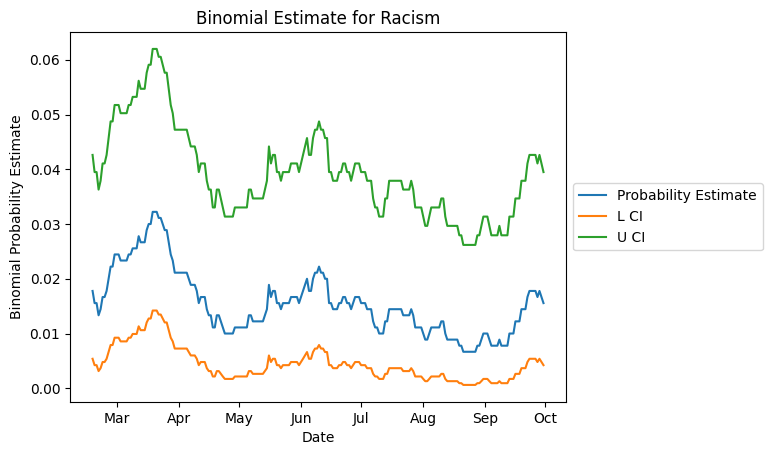

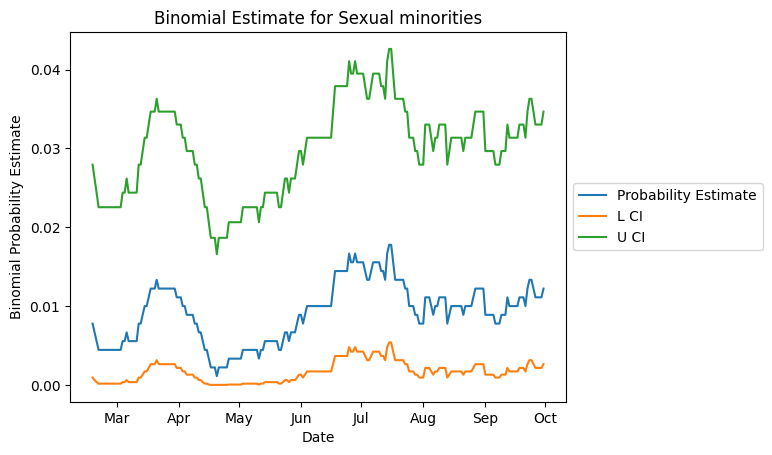

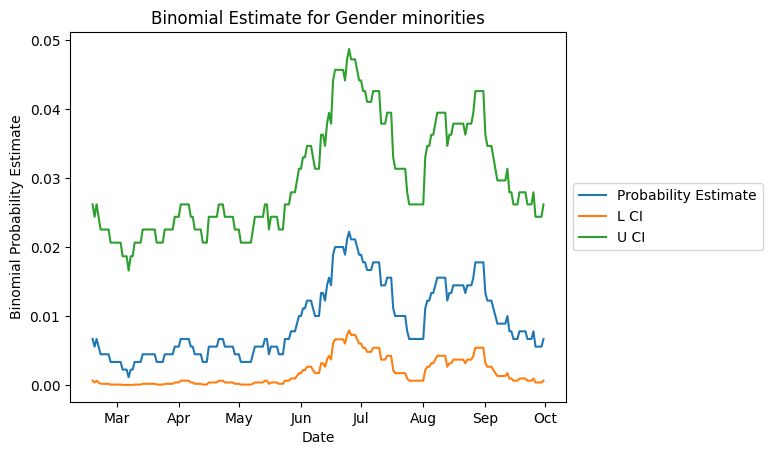

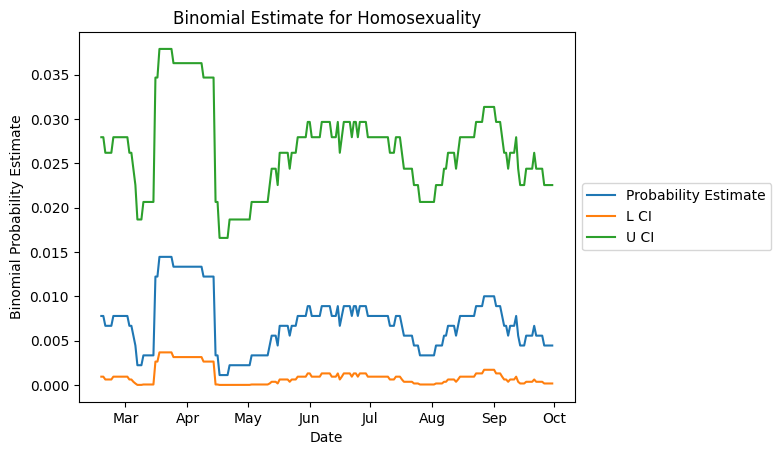

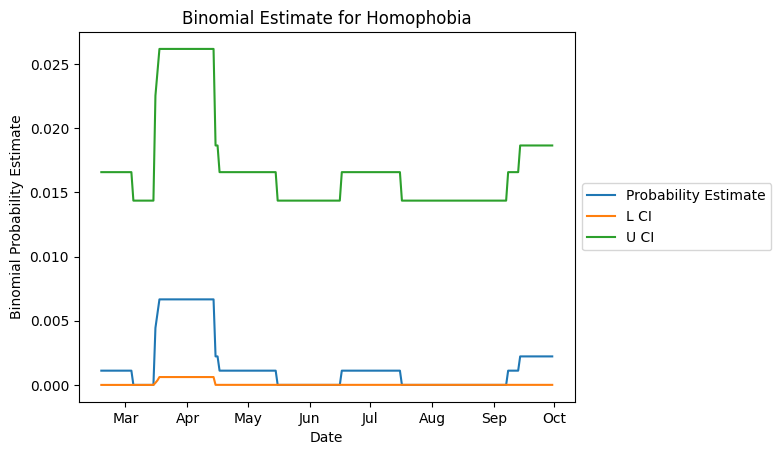

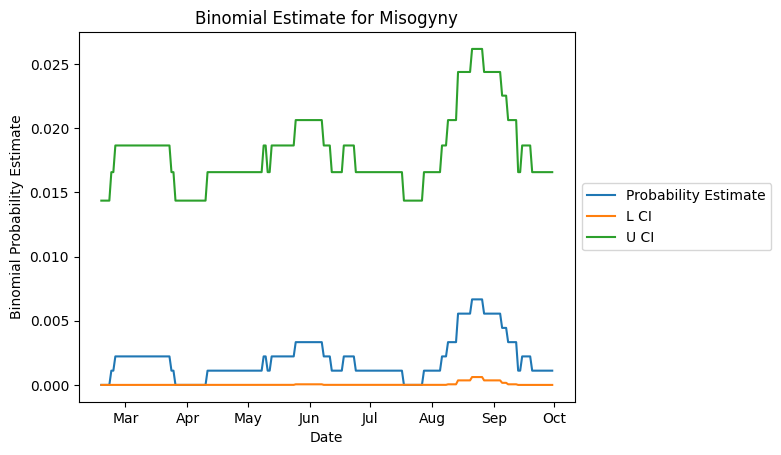

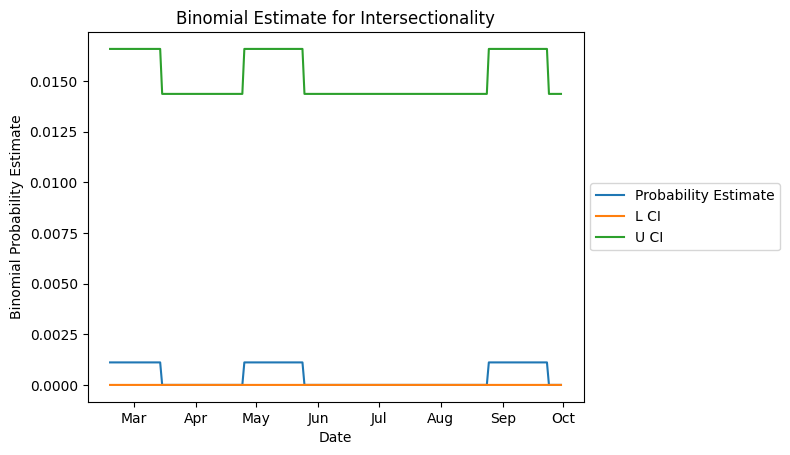

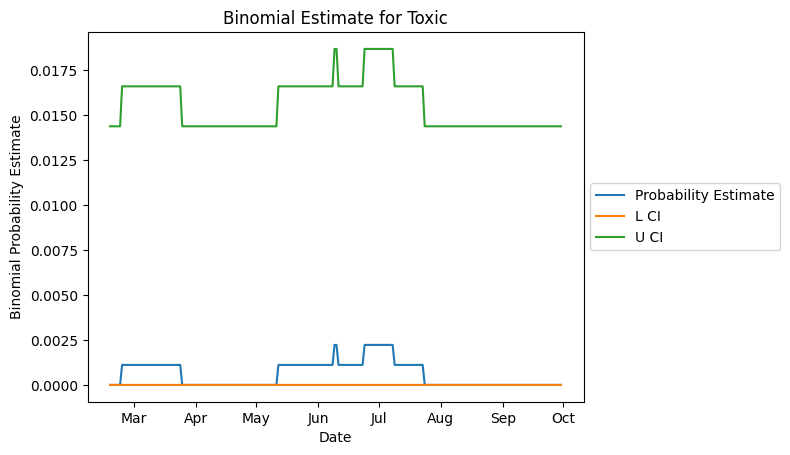

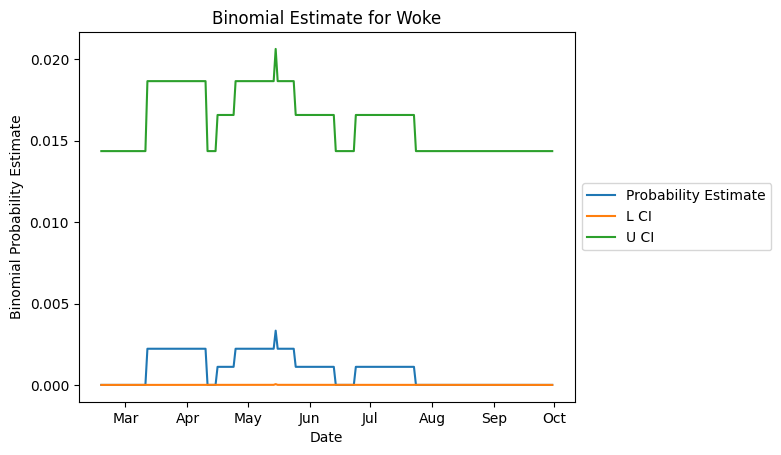

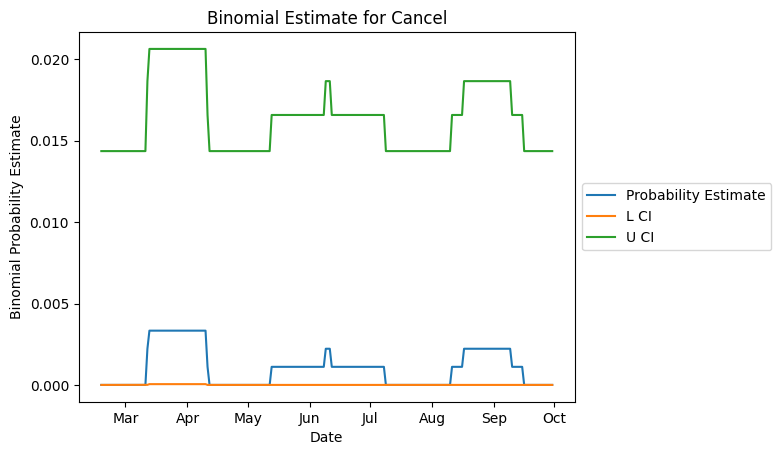

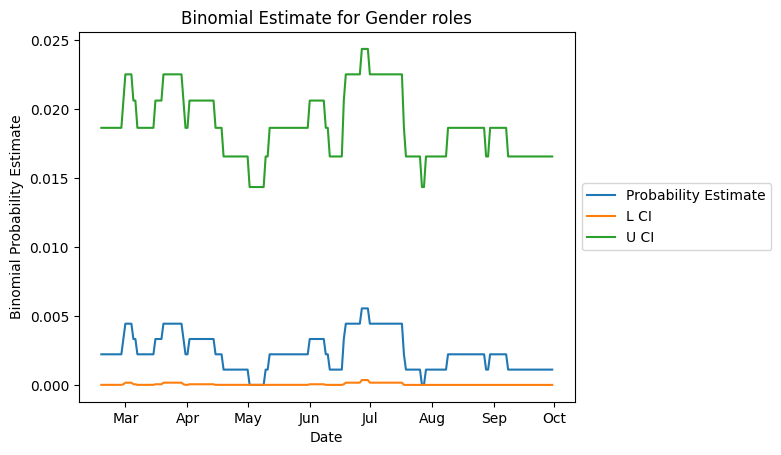

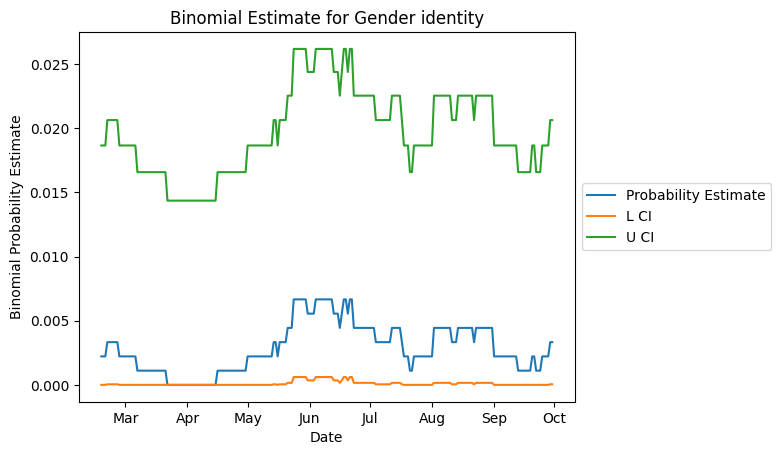

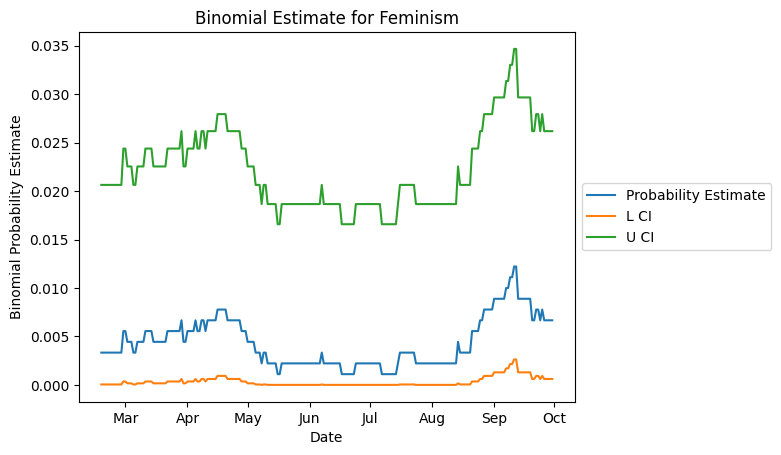

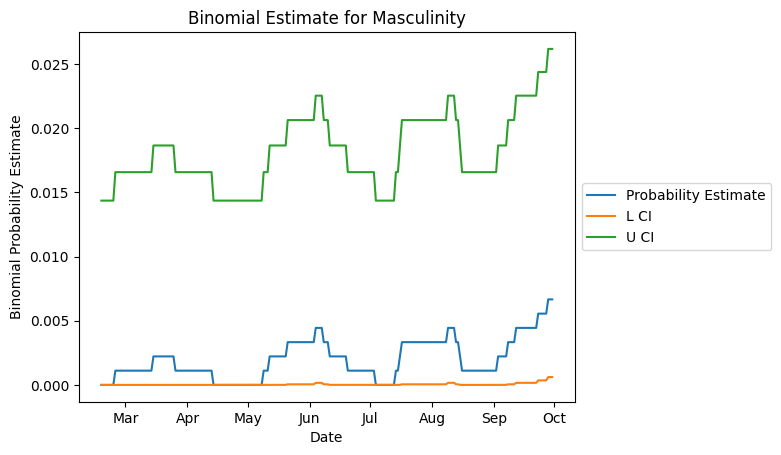

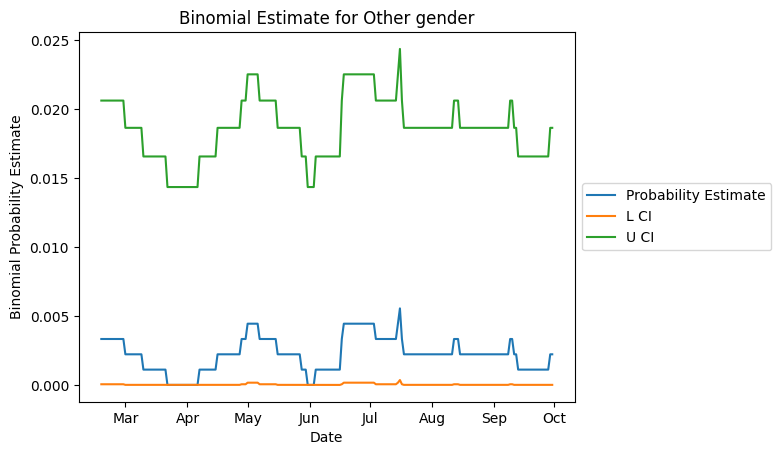

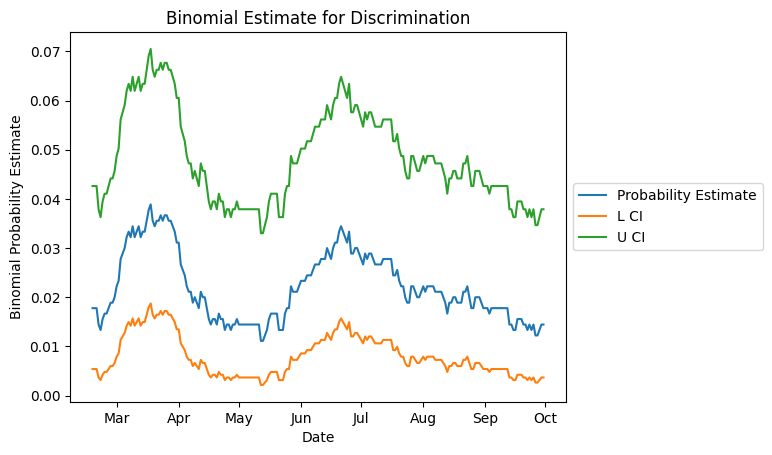

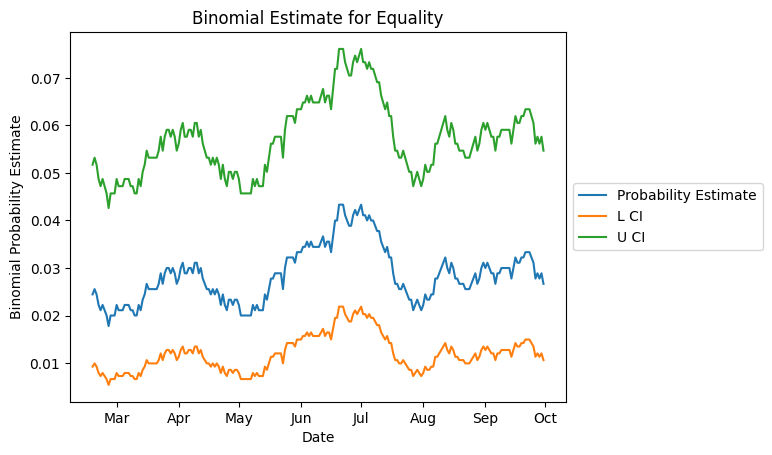

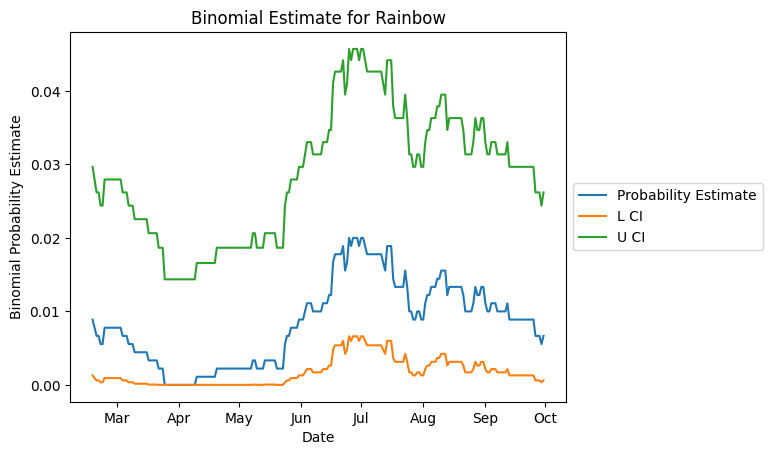

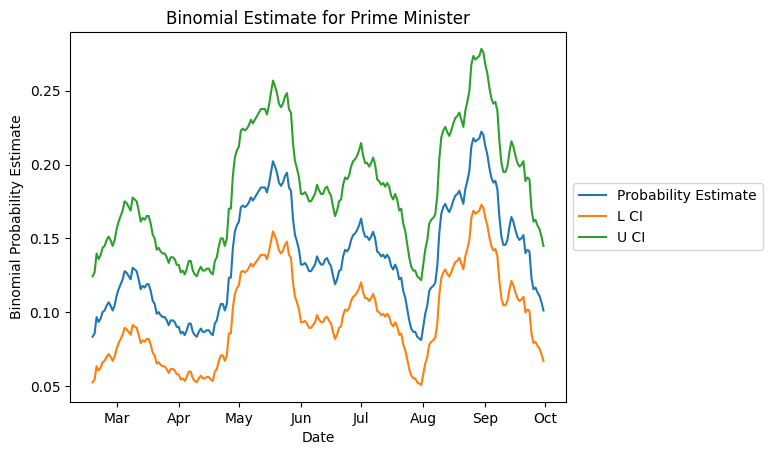

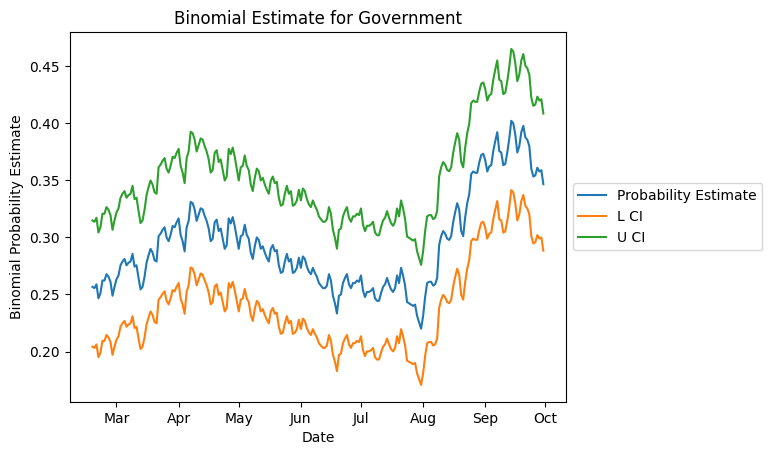

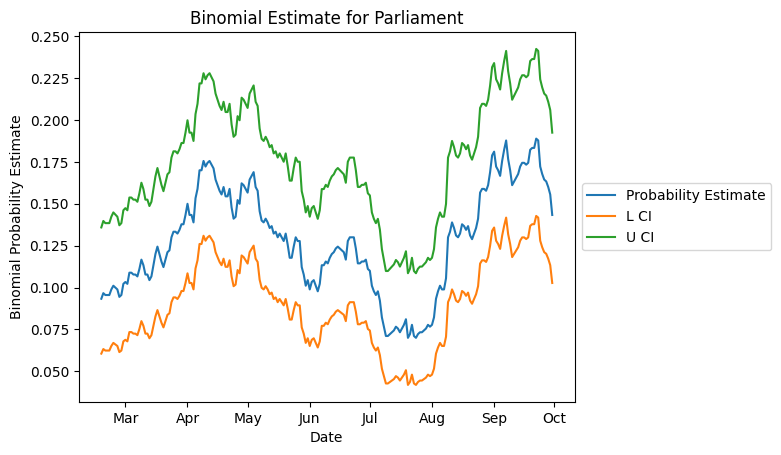

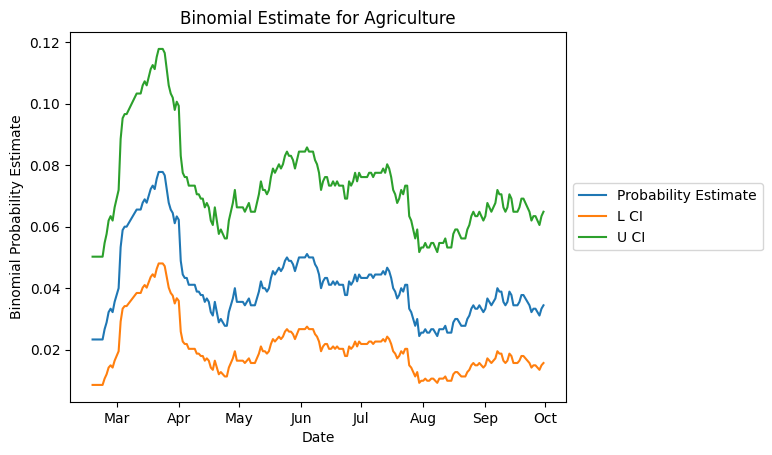

KeyboardInterrupt: 

In [10]:
A.data_run_prob_plot(30,0.05)

In [63]:
class MonteCarlo:
    def __init__(self):
        self.storage= None
        pass
    
    #Specify state model for variance with hyperprior sigma = 5
    def StateSpace_iplus1var(self,xt):
        return(xt*np.random.lognormal(0,0.1)) # SPECIFIES HYPER PRIOR
    def StateSpace_iplus1mean(self,xt,var):
        return(xt*np.random.lognormal(0,var))

    def StateSpace_iplus1corr(self,xt):
        wt = xt + np.random.normal(0,0.1)
        while wt>1 or wt<-1:
            wt = xt
            wt = wt + np.random.normal(0,0.1)
        #print(wt)
        return(wt)
    
    #Specify model for
    def transitionkernelmeans(self,particles,file):
        param = 0
        while param == 0:
            cova = np.sqrt(particles[0])*np.sqrt(particles[1]) * particles[2] #sxsycorrxy
            Cov_mat = np.array([[particles[0],cova],[cova,particles[1]]])
            file.write(str(Cov_mat))
            ans = [particles[3],particles[4]]+np.random.multivariate_normal(mean = [0,0],cov = Cov_mat)
            if ans[0] > 0 and ans[1] >0:
                return(ans)
    
    def hiddenmodel_ipuls1_for_var(self,observation,statemean):
        # dummy  = scipy.stats.norm.pdf(observation,loc = statemean, scale =np.sqrt(statevar))
        dummy = scipy.stats.poisson.pmf(observation,mu = statemean)
        if dummy>0.999999:
            dummy = 1
        elif dummy<1e-8:
            dummy = 0
        return(dummy)
    
    def general_filter(self,obs1,obs2,N):
        self.storage= np.zeros((5,len(obs1)))
        #ParticleStates for given time t:
        #1st row stores the states (1xN) for the var1
        #2nd row stores the states (1xN) for the var2
        #3rd row stores the states for correlation
        #4th stores estimated means for 1st set of obs
        #5th states estimated means for 2nd set of obs

        ParticleStates = np.zeros((5,N))
        MeanStates = np.zeros((2,len(obs1)))
        CovStates = np.empty(len(obs1))

        # Initial prior distribution for our unobservable quantity of interest
        # set variances to be large. Eventually particles will settle to their correct values given the number of observations.
        ParticleStates[0,:] = [np.random.uniform(0,10) for elem in range(N)]
        ParticleStates[1,:] = [np.random.uniform(0,10) for elem in range(N)]
        ParticleStates[2,:] = [np.random.uniform(-1,1) for elem in range(N)]
        ParticleStates[3,:] = [np.random.uniform(0,3) for elem in range(N)]
        ParticleStates[4,:] = [np.random.uniform(0,3) for elem in range(N)]
        
        with open('output.txt','w') as file:
            for i in range(0,len(obs1)):
                #Output our particle states and the estimate for the mean and the variance derived from these separate HMM.
                [ParticleStates,means,cov,vars] = self.Filter(ParticleStates,obs1[i],obs2[i],N,file)
                MeanStates[0,i] = means[0]
                MeanStates[1,i] = means[1]
                CovStates[i] = cov
                # if i%10 ==0:
                #     plt.hist(ParticleStates[0,:])
                #     plt.yscale("log")
                #     plt.title("Particles for variance on "+ str(i)+"th iteration")

                #     plt.xlabel("Particle value")
                #     plt.ylabel("Particle Frequency")

                #     plt.savefig('./Plots/debugging/log_'+str(i))
                    
                #     plt.show()

                self.storage[:,i] = [vars[0],vars[1],cov,means[0],means[1]]

                print('obs ',i) # print observation i
        return(MeanStates,CovStates)
        

    def Filter(self,Particles,Y1obs,Y2obs,N,file):
        Weights = np.zeros((2,N))
        means = np.zeros(2)
        vars = np.zeros(2)

        for i in range(0,N):
            Particles[0,i] = self.StateSpace_iplus1var(Particles[0,i]) # Evolve the variances
            Particles[1,i] = self.StateSpace_iplus1var(Particles[1,i]) # Evolve the variances
            Particles[2,i] = self.StateSpace_iplus1corr(Particles[2,i]) # Evolve the corr
            #print('Before: ',[Particles[3,i],Particles[4,i]])
            [Particles[3,i],Particles[4,i]] = self.transitionkernelmeans(Particles[:,i],file) # Evolve the means with corr parameter
            #print('After: ', [Particles[3,i],Particles[4,i]])

            Weights[0,i] = self.hiddenmodel_ipuls1_for_var(Y1obs,Particles[3,i])
            Weights[1,i] = self.hiddenmodel_ipuls1_for_var(Y2obs,Particles[4,i])
            # print("Weights0: ",Weights[0,i],Y1obs,Particles[3,i],Particles[0,i])
            # print("Weights1: ",Weights[1,i],Y1obs,Particles[4,i],Particles[1,i])

        sumW = np.sum(Weights,axis = 1)
        print(sumW)
        for i in range(N):
            Weights[0,i] = Weights[0,i]/sumW[0]
            Weights[1,i] = Weights[1,i]/sumW[1]

        #Resample from these weights
        I_mean1 = np.random.choice(list(range(N)),replace = True, size = N, p = Weights[0,:])
        Particles[3,:] = Particles[3,:][I_mean1]
        Particles[0,:] = Particles[0,:][I_mean1]
        
        I_mean2 = np.random.choice(list(range(N)),replace = True, size = N, p = Weights[1,:])
        Particles[4,:] = Particles[4,:][I_mean2]
        Particles[1,:] = Particles[1,:][I_mean2]

        #Returns expected mean from particles
        vars[0] = np.mean(Particles[0,:])
        vars[1] = np.mean(Particles[1,:])
        means[0] = np.mean(Particles[3,:])
        means[1] = np.mean(Particles[4,:])

        #Returns expected covariance from particles
        cov = np.mean(Particles[2,:]) 
        return(Particles,means,cov,vars)

In [49]:
df = Model().df


Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


In [64]:
obs1 = list(df.Government)
obs2 = list(df.Parliament)


In [65]:
hi = MonteCarlo()
hi.general_filter(obs1,obs2,2000)

[ 17.45483805 420.90527388]
obs  0
[177.5455278  256.26870753]
obs  1
[ 53.18934374 324.06624157]
obs  2
[ 54.63146979 282.7636916 ]
obs  3
[168.0841728  308.90708803]
obs  4
[ 86.64344747 358.77534816]
obs  5
[203.2728419  292.94517808]
obs  6
[166.28267813 303.56236052]
obs  7
[116.85820721 130.61067055]
obs  8
[92.77782199 96.94561907]
obs  9
[ 92.15129754 357.67201797]
obs  10
[143.97654576 370.69081676]
obs  11
[194.31247263 383.88352116]
obs  12
[167.67855596 392.56162883]
obs  13
[194.98662563 304.64796193]
obs  14
[185.20000906  92.28807729]
obs  15
[170.40629908 215.99125405]
obs  16
[205.19196493 386.33296682]
obs  17
[163.92626881 271.65739686]
obs  18
[238.92104123 497.25782231]
obs  19
[  1.46061852 156.54835289]
obs  20
[153.57119468  23.21075467]
obs  21
[ 90.09001235 100.52960448]
obs  22
[152.46885252 195.50787014]
obs  23
[ 48.71934602 115.1598505 ]
obs  24
[165.47866083 407.50175943]
obs  25
[ 58.82503645 411.47873249]
obs  26
[114.43549467 230.85254004]
obs  27
[157

(array([[ 5.73245443,  6.7393684 , 10.29018785,  5.8482747 ,  3.39180053,
          6.47219249,  6.4570442 ,  7.68763758,  9.72085426, 12.05743147,
          8.90652867,  6.78477085,  6.65373478,  7.766411  ,  7.68365273,
          8.1008135 ,  6.65300395,  6.70220323,  4.68831862,  3.97953544,
         11.66994818, 10.30473306, 13.14698449, 13.11690887,  8.39179326,
          7.23635728,  1.34658855,  5.0456678 ,  6.60493757, 11.25314311,
          9.3842159 , 10.0259197 ,  4.25053876,  6.70919986, 10.13770965,
          9.13667249, 10.49542034,  7.9745425 ,  7.81059469,  4.83189547,
          9.89987879, 10.69869092,  9.96079421, 13.44204295, 11.72238469,
         10.98575015,  1.66277144,  6.8015085 ,  5.19887091,  8.26036528,
          8.43678755,  9.90337057,  6.76504337,  5.33662431,  6.93447425,
         11.46067221, 11.38222011, 12.05406145, 12.17039081, 11.64683142,
          4.39624444,  8.03874035, 16.30946774, 11.88733213, 14.08321776,
         11.87921091,  5.32606282,  4.

In [72]:
mod1 = hi.storage

AttributeError: 'DataFrame' object has no attribute 'storage'

In [71]:
plt.plot(hi.storage[0,:],label = "S2x")
vals = obs1
hip= pd.DataFrame(vals)       
dudevar = pd.DataFrame(hip).rolling(30, center=True).var() 
plt.plot(dudevar['Climate'])
plt.plot(hi.storage[1,:],label = "S2y")
plt.plot(hi.storage[2,:],label = "Corr")
plt.legend()
plt.savefig('./Plots/variances')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'storage'

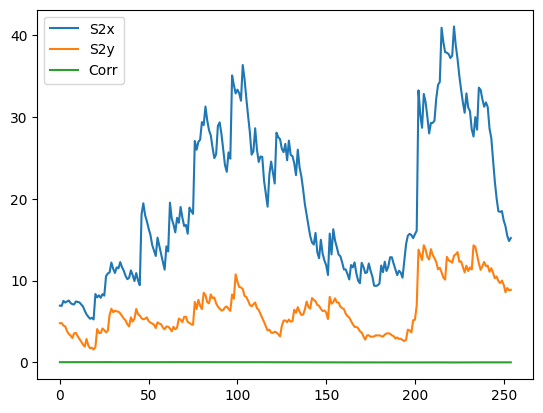

In [68]:
plt.plot(hi.storage[0,:],label = "S2x")
plt.plot(hi.storage[1,:],label = "S2y")
plt.plot(hi.storage[2,:],label = "Corr")
plt.legend()
plt.savefig('./Plots/variances')
plt.show()

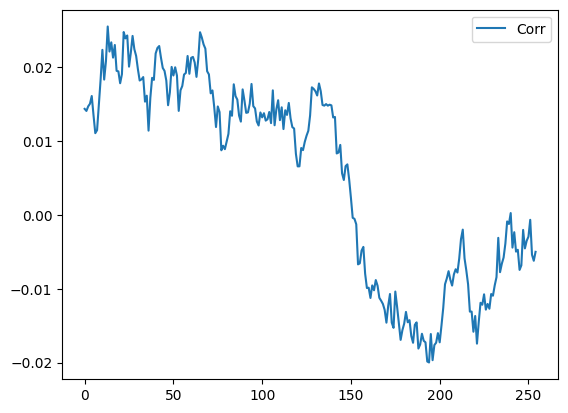

In [69]:
plt.plot(hi.storage[2,:],label = "Corr")
plt.legend()
plt.savefig('./Plots/corr')
plt.show()

In [66]:
np.var(obs1)

23.91366397539408

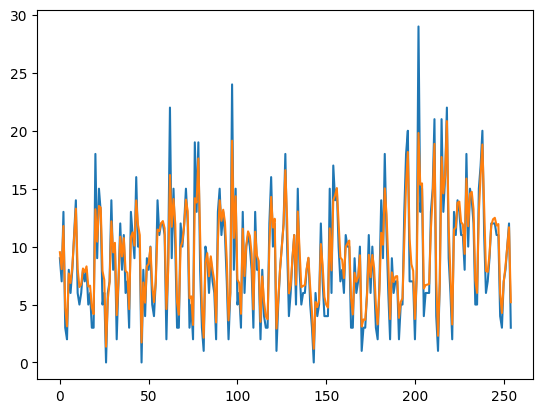

In [59]:
#for 0 or 1 or 2
plt.plot(obs1)
plt.plot(hi.storage[3,:])
plt.show()

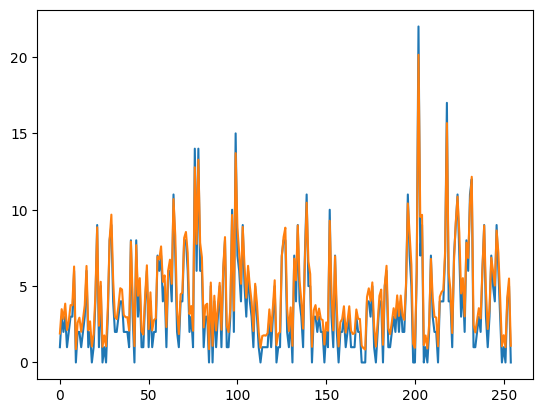

In [19]:
#for 0 or 1 or 2
plt.plot(obs2)
plt.plot(hi.storage[4,:])
plt.show()

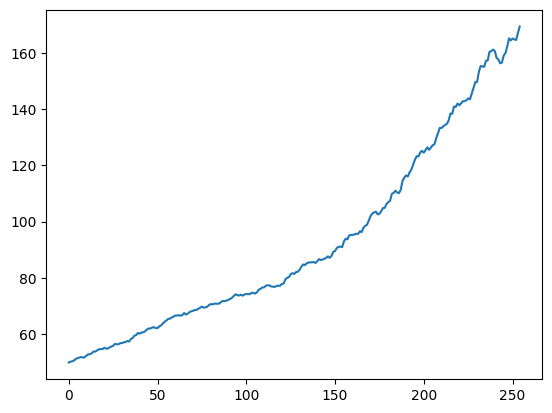

In [20]:
#for 0 or 1 or 2
plt.plot(hi.storage[0,:])
plt.show()

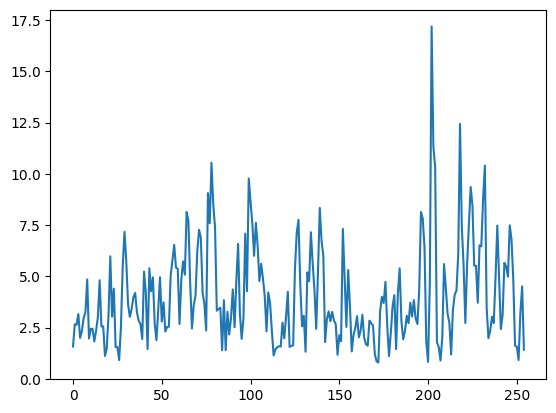

In [12]:
#for 3 or 4
plt.plot(hi.storage[4,:])
plt.show()

In [43]:
cols = list(df)[:-1]
comparison = []
for i in range(0,len(cols)):
    for j in range(0,i):
        hi = MonteCarlo()
        obs1 = list(df[cols[i]]) 
        obs2 = list(df[cols[j]])
        hi.general_filter(obs1,obs2,2000)
        comparison.append(hi.storage)

[252.94962164 254.38243468]
obs  0
[231.098395   190.66042033]
obs  1
[211.97282579 184.58131677]
obs  2
[200.14223124 207.13086347]
obs  3
[218.54023566 200.03027346]
obs  4
[223.01381063 205.07869541]
obs  5
[220.92240844 200.17317741]
obs  6
[223.84917011 216.09054617]
obs  7
[220.9658233 224.3773742]
obs  8
[225.2584679  216.88897785]
obs  9
[220.63203859 216.26701031]
obs  10
[220.49198001 221.21521317]
obs  11
[220.04259803 212.05039473]
obs  12
[220.70187346 218.12287669]
obs  13
[219.84649385 213.36489433]
obs  14
[220.08577962 220.1281416 ]
obs  15
[220.16164896 222.22905264]
obs  16
[216.54511773 220.56930161]
obs  17
[215.25778121 212.4601957 ]
obs  18
[220.74232644 220.20795261]
obs  19
[216.00187828 221.55152123]
obs  20
[214.06002683 217.59010472]
obs  21
[221.41964773 221.69984339]
obs  22
[222.33843495 219.62555841]
obs  23
[224.1873643 213.6361238]
obs  24
[220.4810303  217.29157029]
obs  25
[222.37503654 222.79647723]
obs  26
[217.83129642 221.83391427]
obs  27
[222.5

KeyboardInterrupt: 

<Figure size 1600x1600 with 0 Axes>

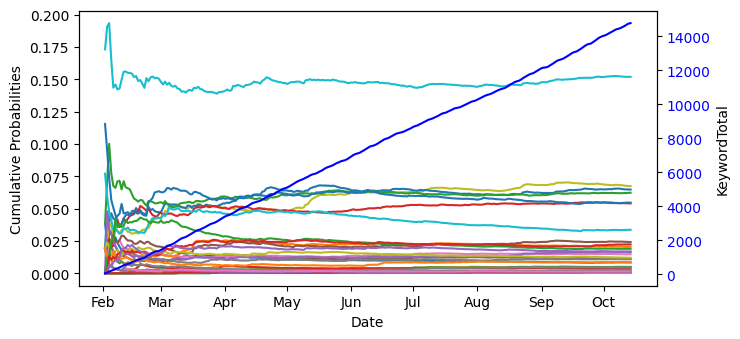

In [29]:
A.plottingcumproball()

In [7]:
A.cumprobdf

,Racism,Sexual minorities,Gender minorities,Homosexuality,Homophobia,Misogyny,Intersectionality,Toxic,Woke,Cancel,...,Act Proposal,School,Labor Unions,Secretary of Defence,Secretary of Foreign Affairs,Mortgage,Demonstrations,Immigration,Secretary of State Home Office,NumOfArticles
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-02,0.038462,0.019231,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.019231,0.000000,0.019231,0.076923,0.115385,0.019231,0.000000,0.000000,0.000000,52
2022-02-03,0.023810,0.023810,0.011905,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011905,0.000000,0.023810,0.059524,0.095238,0.011905,0.011905,0.000000,0.000000,84
2022-02-04,0.033333,0.026667,0.013333,0.006667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006667,0.006667,0.020000,0.046667,0.073333,0.006667,0.013333,0.013333,0.006667,150
2022-02-05,0.030928,0.020619,0.015464,0.005155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005155,0.005155,0.015464,0.041237,0.056701,0.005155,0.025773,0.010309,0.005155,194
2022-02-06,0.025316,0.016878,0.012658,0.004219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004219,0.004219,0.012658,0.033755,0.050633,0.016878,0.025316,0.012658,0.008439,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10,0.008395,0.004954,0.004748,0.003647,0.000757,0.000963,0.000206,0.000275,0.000413,0.000482,...,0.001376,0.010872,0.012110,0.033372,0.054359,0.008463,0.018854,0.022156,0.016858,14533
2022-10-11,0.008359,0.004933,0.004728,0.003631,0.000754,0.000959,0.000206,0.000274,0.000411,0.000480,...,0.001370,0.010826,0.012127,0.033505,0.054402,0.008428,0.018911,0.022268,0.016787,14595
2022-10-12,0.008382,0.004907,0.004702,0.003612,0.000750,0.000954,0.000204,0.000273,0.000409,0.000477,...,0.001363,0.010767,0.012062,0.033461,0.054586,0.008450,0.018877,0.022284,0.016832,14674


In [ ]:
def plottingcumproball(self):
    cols = list(cumdf1)
    cols = cols[1:-1]
    figure(figsize=(10, 10), dpi=160)
    fig, ax1 = plt.subplots()
    for i in range(0,24):
        #plt.plot(cumprobdf1['Date'], cumprobdf1[cols[min(i,23)]])
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True

        
        color = 'red'Q
        
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('exp', color=color)
        ax1.plot(cumprobdf1['Date'], cumprobdf1[cols[min(i,23)]], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()

    color = 'blue'
    ax2.set_ylabel('KeywordTotal', color=color)
    ax2.plot(cumprobdf1['Date'], cumprobdf1[cols[min(i,23)]], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.show()